## JumpyGridWorld Project

## Introduction

In this project, a Q-learning algorithm is implemented for a Jumpy Grid World environment. In this environment, an agent navigates a grid layout that contains obstacles and a goal point within the grid. The agent is able to carry out actions, one of which is a one-of-a-kind leap action, and it also learns to optimize its course in order to maximize the cumulative benefits it receives. JumpyGridWorld, QLearningAgent, and Plotter are few examples of the modular components that are included in the source. In the main.py file, the training loop is responsible for orchestrating the learning process, which includes gathering data for visualizations and changing Q-values. Plots consist of steps for each episode, rewards for each episode, cumulative rewards, exploration decay, a heatmap of Q-values, and a visualization of policy grades. A number of chances for improvement are presented by the implementation, including the possibility of fine-tuning parameters, investigating other grid sizes, enhancing exploration techniques, refining visuals, and taking into consideration parallelization for bigger settings. For example, the implementation allows for straightforward parameter modifications. Through its whole, the project offers a comprehensive investigation of Q-learning within the context of a dynamic grid world, complete with detailed visualizations for the purposes of analysis and interpretation.



## Global.py

Declaring global variables rewards and stepsPerEpisode is the purpose of the Globals.py file, which is a straightforward utility file. In the course of the training process, these variables are responsible for storing cumulative rewards and steps for each episode. Through the process of making them global, many components of the project will have the ability to simply access and update the shared data.


In [1]:
# Globals.py

# Declaring rewards and stepsPerEpisode as global variables
rewards = []
steps_episode = []


## Jumpy_GW.py

A definition of the environment in which the Q-learning agent acquires knowledge is provided by the JumpyGridWorld.py module. In addition to providing methods for resetting the environment, validating valid locations, detecting obstacles, and carrying out actions, the JumpyGridWorld class is responsible for initializing a grid world with obstacles. The learning task is made more difficult by the inclusion of a random component, which is introduced by the leap action.


In [2]:
# JumpyGridWorld Project

## Introduction

## JumpyGW.py

import numpy as np

class JumpyGW:
    
    # Initializing
    def __init__(self, size, number_obstacles):
        self.grid_size = size
        self.grid = np.zeros( (size,size) )
        self.start = (0, 0)
        self.goal = (size - 1, size - 1)
        self.obstacles = set()
        self.agent_path = []

        for i in range(number_obstacles):
            obs_pos = ( np.random.randint(size), np.random.randint(size))
            self.obstacles.add(obs_pos)


    # Reset the environemtn from scrach
    def reset(self):
        self.grid = np.zeros( (self.grid_size, self.grid_size) )
        self.agent_path = []
        return self.start

    # Verify the validity of a position in the grid        
    def position_validation(self, position):
        if ( (0 <= position[0] < self.grid_size) and (0 <= position[1] < self.grid_size) ):
            return True
        else:
            return False
    
    # Determine whether a given position constitutes an obstacle
    def obstacle_check(self, position):
        if (position in self.obstacles):
            return True
        else:
            return False
    
    # Determine whether a given position represents the goal state
    def goal_check(self, position):
        if (position == self.goal):
            return True
        else:
            return False

    # Action Effect Dictionary Definiation
    Action_Effect = {
        0: (-1, 0), # UP
        1: (1, 0), # Down
        2: (0, -1), # Left
        3: (0, 1), #Right
    }
    
    # Execute the designated action and provide the updated position and reward
    def action_execuation(self, position, action):
        if action in self.Action_Effect:
            delta = self.Action_Effect[action]
            new_positon = (position[0] + delta[0], position[1] + delta[1])
        else:
            jump_direction = np.random.choice([-1,1], size = 2)
            new_positon = (position[0] + jump_direction[0], position[1] + jump_direction[1])

        # update postion if valid and not an obstacle
        new_positon = self.update_position(position, new_positon)

        # update grid
        self.update_grid(position, new_positon)

        # calculate reward
        reward = self.calculate_reward(new_positon)

        # add the current position to the agent's path
        self.agent_path.append(new_positon)

        return new_positon, reward
    

    # define update position
    def update_position(self, position, new_positon):
        if self.position_validation(new_positon) and not self.obstacle_check(new_positon):
            return new_positon
        else:
            return position
    
    # define update grid
    def update_grid(self, position, new_positon):
        self.grid[position] = 0
        self.grid[new_positon] = 1
    
    # define calculation reward
    def calculate_reward(self, position):
        if self.goal_check(position):
            return 10
        else:
            return -1
    

## QLearning_Agent

The structure of the Q-learning agent's logic is contained within the QLearningAgent.py script. A Q-table is kept up to date by the QLearningAgent class, which is responsible for storing Q-values for every state-action pair. Methods for selecting actions by employing an epsilon-greedy strategy, updating the Q-table based on rewards and future Q-values, and determining the best policy are all included in this system. The learning rate, discount factor, and exploration rate of the agent are all factors that can be individually adjusted.



In [3]:

import numpy as np

class QLearning_Agent:
    # A Q-table for storage. Q-values representing the expected rewards for each possible action in every state
    def __init__(self, state_size, number_actions, rate_learning, factor_discount, rate_exploration):
        """
        Construct a Q-Learning Agent.

        Args:
        - state_size (tuple): Size of the state space.
        - number_actions (int): Count of potential actions.
        - rate_learning (float): Rate at which the agent learns (alpha).
        - factor_discount (float): Rate at which future rewards are discounted (gamma).
        - rate_exploration (float): Probability of choosing a random action (epsilon).
        """
        # Set up a table for Q-values with initial zero values
        self.qtable = np.zeros(state_size + (number_actions,))
        self.rate_learning = rate_learning
        self.factor_discount = factor_discount
        self.rate_exploration = rate_exploration
        self.number_actions = number_actions
        self.path_episode = [] # Record of the agent's trajectory in an episode


    # Using the epsilon-greedy approach to implement action selection logic
    def action_choose(self, state):
        """
        Decide on an action based on the current state using an epsilon-greedy approach.

        Args:
        - state (tuple): The current state from which to choose an action.

        Returns:
        - (int): The selected action.
        """
        if np.random.rand() < self.rate_exploration:
            return np.random.randint(self.number_actions)
        else:
            return np.argmax(self.qtable[state])
        
    
    # Using the Q-learning update rule to set up Q-table update code
    def qtable_update(self, state, action, reward, state_next):
        """
        Update the Q-table with a new value based on the agent's experience.

        Args:
        - state (tuple): The state prior to taking the action.
        - action (int): The action that was taken.
        - reward (float): The reward received after taking the action.
        - state_next (tuple): The state after the action was taken.
        """

        q_value_current = self.qtable[state][action]
        q_value_next_max = np.max(self.qtable[state_next])
        q_value_updated = (1 - self.rate_learning) * q_value_current + \
                          self.rate_learning * (reward + self.factor_discount * q_value_next_max)
        self.qtable[state][action] = q_value_updated

    def episode_path_reset(self):
        """
        Clear the record of the agent's path for a new episode.
        """
        self.path_episode = []

    def get_policy_optimal(self, obstacles):
        """
        Create an optimal policy based on the highest Q-values in the Q-table.

        Args:
        - obstacles (np.array): A grid indicating where obstacles are present.

        Returns:
        - policy_optimal (np.array): The derived optimal policy grid.
        """
        # Initialize the policy grid, defaulting to -1 for obstacles
        policy_optimal = np.full(self.qtable.shape[:-1], -1, dtype=int) 

        for state in np.ndindex(policy_optimal.shape):
            if not obstacles[state]:
                q_value_max = np.max(self.qtable[state])
                actions_best = np.where(self.qtable[state] == q_value_max)[0]
                action_chosen = np.random.choice(actions_best)  # Select among the best actions
                policy_optimal[state] = action_chosen

        return policy_optimal
    

## Plotter.py

Plotter.py is primarily concerned with visualization features that are designed to assist in comprehending the behavior of the Q-learning agent. Matplotlib is utilized by the module in order to generate heatmaps for Q-values and policy grades. The module includes functions such as visualizePath, visualizeQValuesOnAxes, and visualizePolicyGradeOnAxes. The updatePlots function is responsible for providing dynamic updates to plots while training is being performed. These updates display the evolution of rewards, steps per episode, Q-values, ideal path, and policy grades.


In [4]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
from Globals_Variables import rewards, steps_episode


# Function to convert actions into visual symbols
def map_action_to_symbol(action):
    arrow_map = {
        0: '↑',  # Up
        1: '↓',  # Down
        2: '←',  # Left
        3: '→',  # Right
        4: '⇆'   # Jump
    }
    # Fallback to '?' when the action is not found in the mapping
    if action in arrow_map:
        return arrow_map.get(action)
    else:
        return '?'


# Function to plot the agent's path on the grid
def draw_agent_route (size, agent_path, axis):
    axis.clear()
    axis.set_title(r'$\bf{Agent\'s\ Trajectory\ Path}$', fontsize=14)
    axis.set_xlabel('Grid Width')
    axis.set_ylabel('Grid Height')
    axis.set_xticks(np.arange(size+1))  # Add +1 to include the edge for better visualization
    axis.set_yticks(np.arange(size+1))  # Add +1 to include the edge for better visualization
    axis.grid(which='both', color='red', linestyle='-', linewidth=2)
    x_coords = [coord[0] for coord in agent_path]
    y_coords = [coord[1] for coord in agent_path]
    axis.plot(np.array(y_coords)+0.5, np.array(x_coords)+0.5, marker='o', linestyle='-', color='blue')  # Add +0.5 to center the markers in the cells
    axis.invert_yaxis()  # Invert y-axis to match the visualization of the grade


# Function to create a heatmap representation of the highest Q-values
def render_qvalue_heatmap(q_values, axis):
    axis.clear()
    optimal_qvalues = np.max(q_values, axis=2)
    heatmap = axis.matshow(optimal_qvalues, cmap='cool')
    colorbar = plt.colorbar(heatmap, ax=axis)
    colorbar.ax.set_ylabel('Q-values', rotation=-90, va="bottom")
    axis.set_title('Heatmap of Optimal Q-values', pad=20)
    axis.set_xlabel('Width of Grid')
    axis.set_ylabel('Height of Grid')
    axis.set_xticks(np.arange(q_values.shape[1]))
    axis.set_yticks(np.arange(q_values.shape[0]))


# Function to display the agent's policy on a grid
def display_agent_policy_on_grid(q_values, axis):
    axis.clear()
    # Determine the best action (highest Q value) for each state
    optimal_actions = np.argmax(q_values, axis=2)

    action_values_mapping = {
        0: 0.25,  # Assign 0.25 to 'Up' action
        1: 0.50,  # Assign 0.50 to 'Down' action
        2: 0.75,  # Assign 0.75 to 'Left' action
        3: 1.0,   # Assign 1.0 to 'Right' action
        4: 0.0    # Assign 0.0 to 'Jump' action
    }   

    # Map the optimal actions to their corresponding visualization values
    policy_display_values = np.vectorize(action_values_mapping.get, otypes=[float])(optimal_actions)

    # Create a matrix display of the policy values with a color map
    color_axis = axis.matshow(policy_display_values, cmap='cool', aspect='equal')

    # Configure the color map and normalization for the color bar
    color_map = plt.cm.cool
    color_norm = Normalize(vmin=0.0, vmax=1.0)

    # Create a ScalarMappable for the color bar
    scalar_mapper = ScalarMappable(cmap=color_map, norm=color_norm)
    scalar_mapper.set_array([])

    # Add a color bar with specific tick labels for each action
    color_bar = plt.colorbar(scalar_mapper, ax=axis, ticks=[0.0, 0.25, 0.50, 0.75, 1.0])
    color_bar.ax.set_yticklabels(['Jump', 'Up', 'Down', 'Left', 'Right'])  # Label the ticks with action names

    # Overlay action arrows on the grid
    for row_index, row in enumerate(optimal_actions):
        for col_index, action_code in enumerate(row):
            # action_arrow = action_values_mapping(action_code)
            action_arrow = action_values_mapping[action_code]
            axis.text(col_index, row_index, action_arrow, horizontalalignment='center', verticalalignment='center', fontsize = 10, color='black')

    # Set grid lines centered on each cell edge
    axis.set_xticks(np.arange(optimal_actions.shape[1]) - 0.5, minor=True)
    axis.set_yticks(np.arange(optimal_actions.shape[0]) - 0.5, minor=True)
    
    # Draw the grid lines
    axis.grid(which='minor', color='black', linestyle='-', linewidth=2)
    
    # Remove tick marks
    axis.tick_params(axis='both', which='both', length=0)
    
    # Set the title for the axes
    axis.set_title('Optimal Policy Visualization\n')


# Function to update visualization plots after training episodes
def refresh_visualization(episode_number, agent, axis_steps, axis_rewards, axis_cumulative_rewards, axis_policy, axis_qvalues, axis_path, environment, path_of_episode):
    global rewards, steps_episode  # Referencing global variables
    final_episode = agent.number_episodes - 1  # Check if it's the last episode
    if episode_number == final_episode:  # Update plots only after the last training episode
        render_qvalue_heatmap(agent.qtable, axis_qvalues)
        display_agent_policy_on_grid(agent.qtable, axis_policy)
        axis_policy.set_title(r'$\bf{Visualization\ of\ Policy\ Grades}$', fontsize=14)
        axis_qvalues.set_title(r'$\bf{Heatmap\ of\ Q-values}$', fontsize=14)
        axis_path.set_title(r'$\bf{Path\ Taken\ by\ Agent}$', fontsize=14)

        # Plot the number of steps per episode
        axis_steps.plot(range(episode_number + 1), steps_episode, color='blue')
        axis_steps.set_xlabel('Episode')
        axis_steps.set_ylabel('Steps')
        axis_steps.set_title(r'$\bf{Episode\ vs.\ Steps}$', fontsize=14)

        # Plot the rewards obtained per episode
        axis_rewards.plot(range(episode_number + 1), rewards, color='magenta')
        axis_rewards.set_xlabel('Episode')
        axis_rewards.set_ylabel('Reward')
        axis_rewards.set_title(r'$\bf{Episode\ vs.\ Rewards}$', fontsize=14)

        # Plot the accumulated rewards over all episodes
        accumulated_rewards = np.cumsum(rewards)
        axis_cumulative_rewards.plot(range(episode_number + 1), accumulated_rewards, color='green')
        axis_cumulative_rewards.set_xlabel('Episode')
        axis_cumulative_rewards.set_ylabel('Total Reward')
        axis_cumulative_rewards.set_title(r'$\bf{Episode\ vs.\ Cumulative\ Reward}$', fontsize=14)

        # Display the agent's path during the episode
        draw_agent_route(environment.grid_size, path_of_episode, axis_path)

        # Adjust the spacing between plot rows and columns
        plt.subplots_adjust(hspace=0.4, wspace=0.3)

## main.py

The entire process of reinforcement learning is orchestrated by the main.py Python file. Initially, it sets up the JumpyGridWorld environment by utilizing the parameters that have been supplied, which include the grid size, the number of obstacles, and the action size. An instantiation of a Q-learning agent follows this step. across the process of iterating across episodes, the training loop updates the Q-table based on the actions taken by the agent and the answers received from the environment. Collecting data for visualization purposes includes things like prizes, the number of steps taken in each episode, grid layouts, and performance indicators. The last step of the script involves determining and publishing the optimal policy based on the Q-values that have been learned, as well as displaying a number of charts that illustrate the progression of the training.


Ongoing training...
Training has been completed.

Optimal Solution and Policy:
State (0, 0): Move ↓
State (0, 1): Move ↓
State (0, 2): Move ↑
State (0, 3): Move →
State (0, 4): Move ⇆
State (0, 5): Move →
State (0, 6): Move →
State (0, 7): Move ↓
State (0, 8): Move →
State (0, 9): Move ↑
State (1, 0): Move ↓
State (1, 1): Move ↓
State (1, 2): Move →
State (1, 3): Move ↓
State (1, 4): Move →
State (1, 5): Move →
State (1, 6): Move ↓
State (1, 7): Move →
State (1, 8): Move →
State (1, 9): Move ↓
State (2, 0): Move ↓
State (2, 1): Move ↓
State (2, 2): Move →
State (2, 3): Move ↓
State (2, 4): Move →
State (2, 5): Move →
State (2, 6): Move ↓
State (2, 7): Move ⇆
State (2, 8): Move ↓
State (2, 9): Move ↓
State (3, 0): Move ↓
State (3, 1): Move ↓
State (3, 2): Move ↓
State (3, 3): Move ↓
State (3, 4): Move →
State (3, 5): Move →
State (3, 6): Move ↓
State (3, 7): Move ↓
State (3, 8): Move →
State (3, 9): Move ↓
State (4, 0): Move →
State (4, 1): Move →
State (4, 2): Move →
State (4, 3): Move

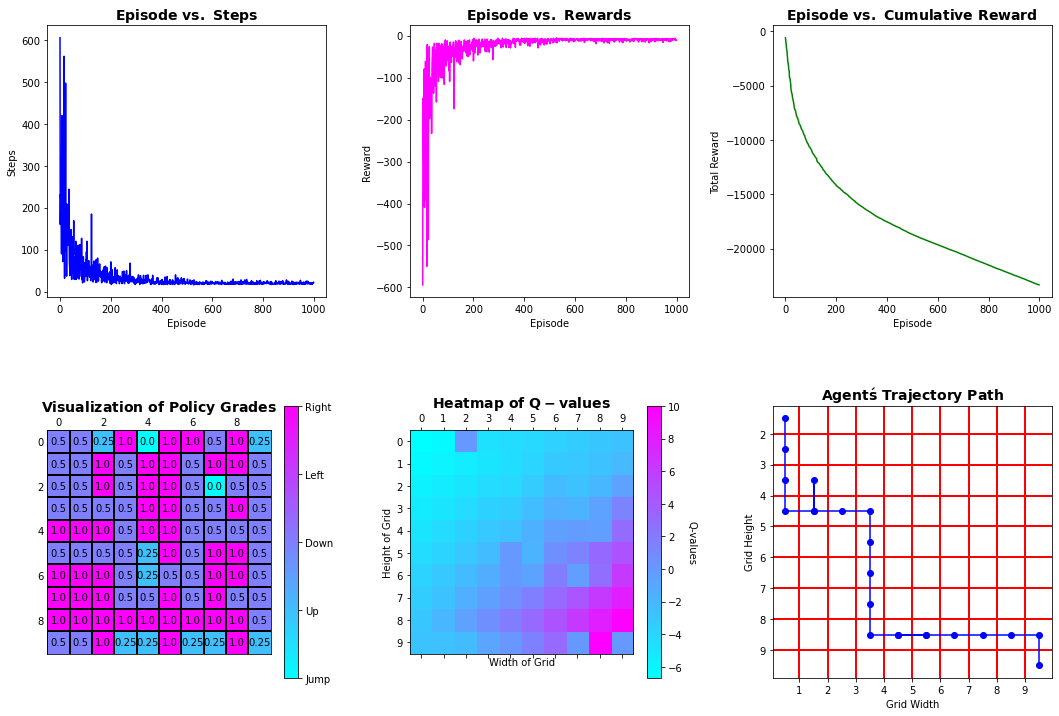

In [5]:

import numpy as np
import matplotlib.pyplot as plt
from Jumpy_GW import JumpyGW
from QLearning_Agent import QLearning_Agent
from Plotter import draw_agent_route, render_qvalue_heatmap, display_agent_policy_on_grid, refresh_visualization
from Globals_Variables import rewards, steps_episode
from Plotter import map_action_to_symbol


# Function to set up the simulation with a predefined environment and agent
def configure_simulation():
    # Seed the random number generator for reproducibility
    # temp_seed = np.random.randint(0, 100)
    # print("seed = ", temp_seed)
    # np.random.seed(temp_seed)
    np.random.seed(56)

    # Define parameters for the grid world and Q-learning agent
    params = {
        'grid_size': 10,         # Size of the grid world
        'number_obstacles': 5,        # Number of obstacles in the grid world
        'state_size': (10, 10), # Shape of the state space
        'number_actions': 5,          # Number of possible actions
        'learning_rate': 0.1,    # Learning rate for Q-learning updates
        'discount_factor': 0.9,  # Discount factor for future rewards
        'exploration_rate': 0.1, # Rate at which the agent explores the environment
        'episodes': 1000         # Number of episodes to run the simulation
    }

    # Initialize the grid world and agent with the specified parameters
    environment = JumpyGW(params['grid_size'], params['number_obstacles'])
    agent = QLearning_Agent(params['state_size'], params['number_actions'], params['learning_rate'], params['discount_factor'], params['exploration_rate'])
    agent.number_episodes = params['episodes']
    
    return environment, agent, params

# Function to run the simulation of the environment and agent interaction
def run_simulation(environment, agent, params):
    # Set up plotting
    figure, axes = plt.subplots(2, 3, figsize=(18, 12))
    axes_list = axes.flatten()
    # ax1, ax2, ax3, ax4, ax5, ax6 = axes.flatten()

    # Clear any previous metrics
    rewards.clear()
    steps_episode.clear()
    grid_layouts = []
    performance = []
    episode_path = []

    # Run the simulation for the specified number of episodes
    print("Ongoing training...")
    for episode_num in range(params['episodes']):
        current_state = environment.reset() # Reset the environment
        total_reward = 0 # Initialize total reward for the episode
        episode_qvalues = []
        
        agent.episode_path_reset() # Initialize agent's path for the new episode

        # Iterate until the agent reaches a final state
        while not environment.goal_check(current_state):
            action = agent.action_choose(current_state) # Agent selects an action
            next_state, reward = environment.action_execuation(current_state, action) # Environment responds
            agent.qtable_update(current_state, action, reward, next_state) # Agent updates its knowledge

            current_state = next_state # Move to the next state
            total_reward += reward # Accumulate rewards
            episode_qvalues.append(np.copy(agent.qtable[current_state]))
            agent.path_episode.append(current_state) # Record the new state

        # Record episode metrics
        rewards.append(total_reward)
        steps_taken = len(episode_qvalues)
        steps_episode.append(steps_taken)
        performance.append(total_reward / steps_taken)

        # Plot statistics after each episode
        grid_layout = np.zeros_like(environment.grid)
        obstacle_position = list(environment.obstacles)
        grid_layout[tuple(zip(*obstacle_position))] = -1
        grid_layout[environment.goal] = 0.5
        grid_layout[current_state] = 0.8
        grid_layouts.append(grid_layout)

        # Update episode_path
        episode_path = agent.path_episode              
        refresh_visualization(episode_num, agent, axes_list[0], axes_list[1], axes_list[2], axes_list[3], axes_list[4], axes_list[5], environment, episode_path)

        # Visualize the agent's trajectory path
        draw_agent_route(params['grid_size'], episode_path, axes_list[5])

    # Simulation is complete
    print("Training has been completed.")

    # Extract and display the optimal policy derived from Q-values
    optimal_policy = make_optimal_policy(environment, grid_layouts, agent)
    display_policy(optimal_policy)
    plt.show() # Display all the plots

# Function to make the optimal policy
def make_optimal_policy(env, grid_layouts, agent):
    optimal_policy = np.zeros_like(env.grid, dtype = int)
    for i in range(optimal_policy.shape[0]):
        for j in range(optimal_policy.shape[1]):
            if grid_layouts[-1][i, j] != -1:
                optimal_policy[i, j] = np.argmax(agent.qtable[i, j])
    
    return optimal_policy

# 
# Function to display the optimal policy in a human-readable format
def display_policy(policy):
    print("\nOptimal Solution and Policy:")
    # Iterate through all states in the policy
    for i in range(policy.shape[0]):
        for j in range(policy.shape[1]):
            action = policy[i, j]
            print(f"State ({i}, {j}): Move {map_action_to_symbol(action)}")

    print("\nOptimal Policy:")
    print(policy)

# Main entry point for the script
def main():
    # Configure the environment and agent, and fetch simulation parameters
    environment, q_agent, simulation_params = configure_simulation()
    # Run the simulation with the configured environment and agent
    run_simulation(environment, q_agent, simulation_params)

if __name__ == "__main__":
    main() # Execute the main function if the script is run directly


## Plots

### Steps per Episode

The goal is to demonstrate how the number of steps that the agent takes in each episode of the show has changed over time.
The interpretation of a diminishing trend is that it indicates the agent's increasing proficiency in efficiently traversing the environment.

### Rewards per Episode

In each episode, the objective is to shed light on the entire prize that the agent has successfully obtained.
The interpretation is that a rising trajectory indicates that the agent has successfully grasped the optimal policy.

### Cumulative Reward per Episode Plots

One of the goals is to see the total amount of incentives that the agent has received over time.
The interpretation of an upward slope is that it suggests that the agent is continually achieving higher cumulative rewards.

### Agents Trajectory Path

The objective is to create a visual representation of the agent's trajectory path on a grid environment in order to exhibit its movement over episodes.
The sequential trajectory of the agent is represented by the line that has been plotted with markers, which provides a spatial knowledge of the agent's movement inside the grid world.

### Q-values Heatmap

The goal is to shed light on the Q-values that are present across the grid world and provide insights into the values that have been learned for each state-action pair.
According to this interpretation, regions that are brighter indicate greater Q-values, which are a reflection of the agent's learning preferences for particular acts in particular conditions.


### Policy Grade Visualization

The goal is to generate a visual representation of the agent's policy by displaying the most appropriate action (arrow) for each grid cell.
The agent's preferred actions at each location are demonstrated by the arrows in the visual representation. Upon closer inspection, a consistent arrangement of arrows reveals a learnt strategy for navigating the grid world.



## Results

By effectively learning how to navigate the grid world, the agent is able to successfully reach the goal state. It is clear from the visualizations that the agent's performance has significantly improved over time. It can be seen from the Q-values heatmap that the agent acquires the ability to prioritize routes that produce larger predicted rewards. The depiction of the policy grade demonstrates that the agent is gaining more self-assurance in the acts that it has chosen. The steps per episode plot demonstrates a decrease in the number of steps as the agent learns, which indicates that navigation becomes more efficient. As the agent gains knowledge, the rewards per episode plot demonstrates an increase in reward, which indicates that the agent is maximizing rewards more effectively. Throughout the course of the training procedure, the cumulative rewards plot demonstrates a steady rise in the amount of rewards received. In addition, we demonstrate the path that the agents take, which is also the best way.

In order to successfully perform a navigation challenge, this project successfully displays the application of reinforcement learning. With the help of the Q-learning algorithm, the agent was able to gather knowledge from its past experiences and arrive at the best possible choices in a dynamic setting.
